In [1]:
#调用库合集

#数据操作
import numpy as np
import pandas as pd
import missingno as msno

#绘图
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
sns.set_palette('rainbow')#调色盘

#设置
import warnings
warnings.filterwarnings('ignore')

#机器学习模型库
import shap
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plt.style.use('ggplot')

#### 1.数据输入及说明

The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 98 and 99 are missing data.

In [3]:
df = pd.read_csv("Covid Data.csv")
# 将除 'AGE'（年龄） 列之外的所有列中的值为 97 98 99 替换为缺失值
columns_to_replace = df.drop('AGE', axis=1).columns
df[columns_to_replace] = df[columns_to_replace].replace([97, 98, 99], np.nan)

# 将除了'MEDICAL_UNIT','CLASIFFICATION_FINAL','AGE'列 之外的所有列中的值为2替换为0
columns_to_replace = df.drop(['MEDICAL_UNIT','CLASIFFICATION_FINAL','AGE'], axis=1).columns
df[columns_to_replace] = df[columns_to_replace].replace(2,0)

# 展示清理结果
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,0,1,1,1,03/05/2020,NaN,1.0,65,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,NaN
1,0,1,0,1,03/06/2020,NaN,1.0,72,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,5,NaN
2,0,1,0,0,09/06/2020,1.0,0.0,55,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0
3,0,1,1,1,12/06/2020,NaN,0.0,53,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN
4,0,1,0,1,21/06/2020,NaN,0.0,68,NaN,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,NaN


In [4]:
# 数据维度
print('预处理前的数据维度大小: ',df.shape)

预处理前的数据维度大小:  (1048575, 21)


In [5]:
# 数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   USMER                 1048575 non-null  int64  
 1   MEDICAL_UNIT          1048575 non-null  int64  
 2   SEX                   1048575 non-null  int64  
 3   PATIENT_TYPE          1048575 non-null  int64  
 4   DATE_DIED             1048575 non-null  object 
 5   INTUBED               192706 non-null   float64
 6   PNEUMONIA             1032572 non-null  float64
 7   AGE                   1048575 non-null  int64  
 8   PREGNANT              521310 non-null   float64
 9   DIABETES              1045237 non-null  float64
 10  COPD                  1045572 non-null  float64
 11  ASTHMA                1045596 non-null  float64
 12  INMSUPR               1045171 non-null  float64
 13  HIPERTENSION          1045471 non-null  float64
 14  OTHER_DISEASE         1043530 non-

In [6]:
# 查看每列的数据独特数量
# 查看每列的独特值
for i in df.columns:
    print(i,"=>\t",len(df[i].unique()))

# 值为3的说明有缺失值

USMER =>	 2
MEDICAL_UNIT =>	 13
SEX =>	 2
PATIENT_TYPE =>	 2
DATE_DIED =>	 401
INTUBED =>	 3
PNEUMONIA =>	 3
AGE =>	 121
PREGNANT =>	 3
DIABETES =>	 3
COPD =>	 3
ASTHMA =>	 3
INMSUPR =>	 3
HIPERTENSION =>	 3
OTHER_DISEASE =>	 3
CARDIOVASCULAR =>	 3
OBESITY =>	 3
RENAL_CHRONIC =>	 3
TOBACCO =>	 3
CLASIFFICATION_FINAL =>	 7
ICU =>	 3


In [7]:
# 查看一下MEDICAL_UNIT具体的组成（因为其定义不清晰）
df.MEDICAL_UNIT.value_counts()
# 根据结果，建议将其转化为哑变量处理，因为定序并并没有什么意义

12    602995
4     314405
6      40584
9      38116
3      19175
8      10399
10      7873
5       7244
11      5577
13       996
7        891
2        169
1        151
Name: MEDICAL_UNIT, dtype: int64

In [8]:
# 查看一下MEDICAL_UNIT具体的组成（因为其定义不清晰）
df.CLASIFFICATION_FINAL.value_counts()
# 根据结果，建议将其转化为哑变量处理，因为定序并并没有什么意义

7    499250
3    381527
6    128133
5     26091
1      8601
4      3122
2      1851
Name: CLASIFFICATION_FINAL, dtype: int64

### 2.数据清洗

#### 2.1缺失值查看

<AxesSubplot:>

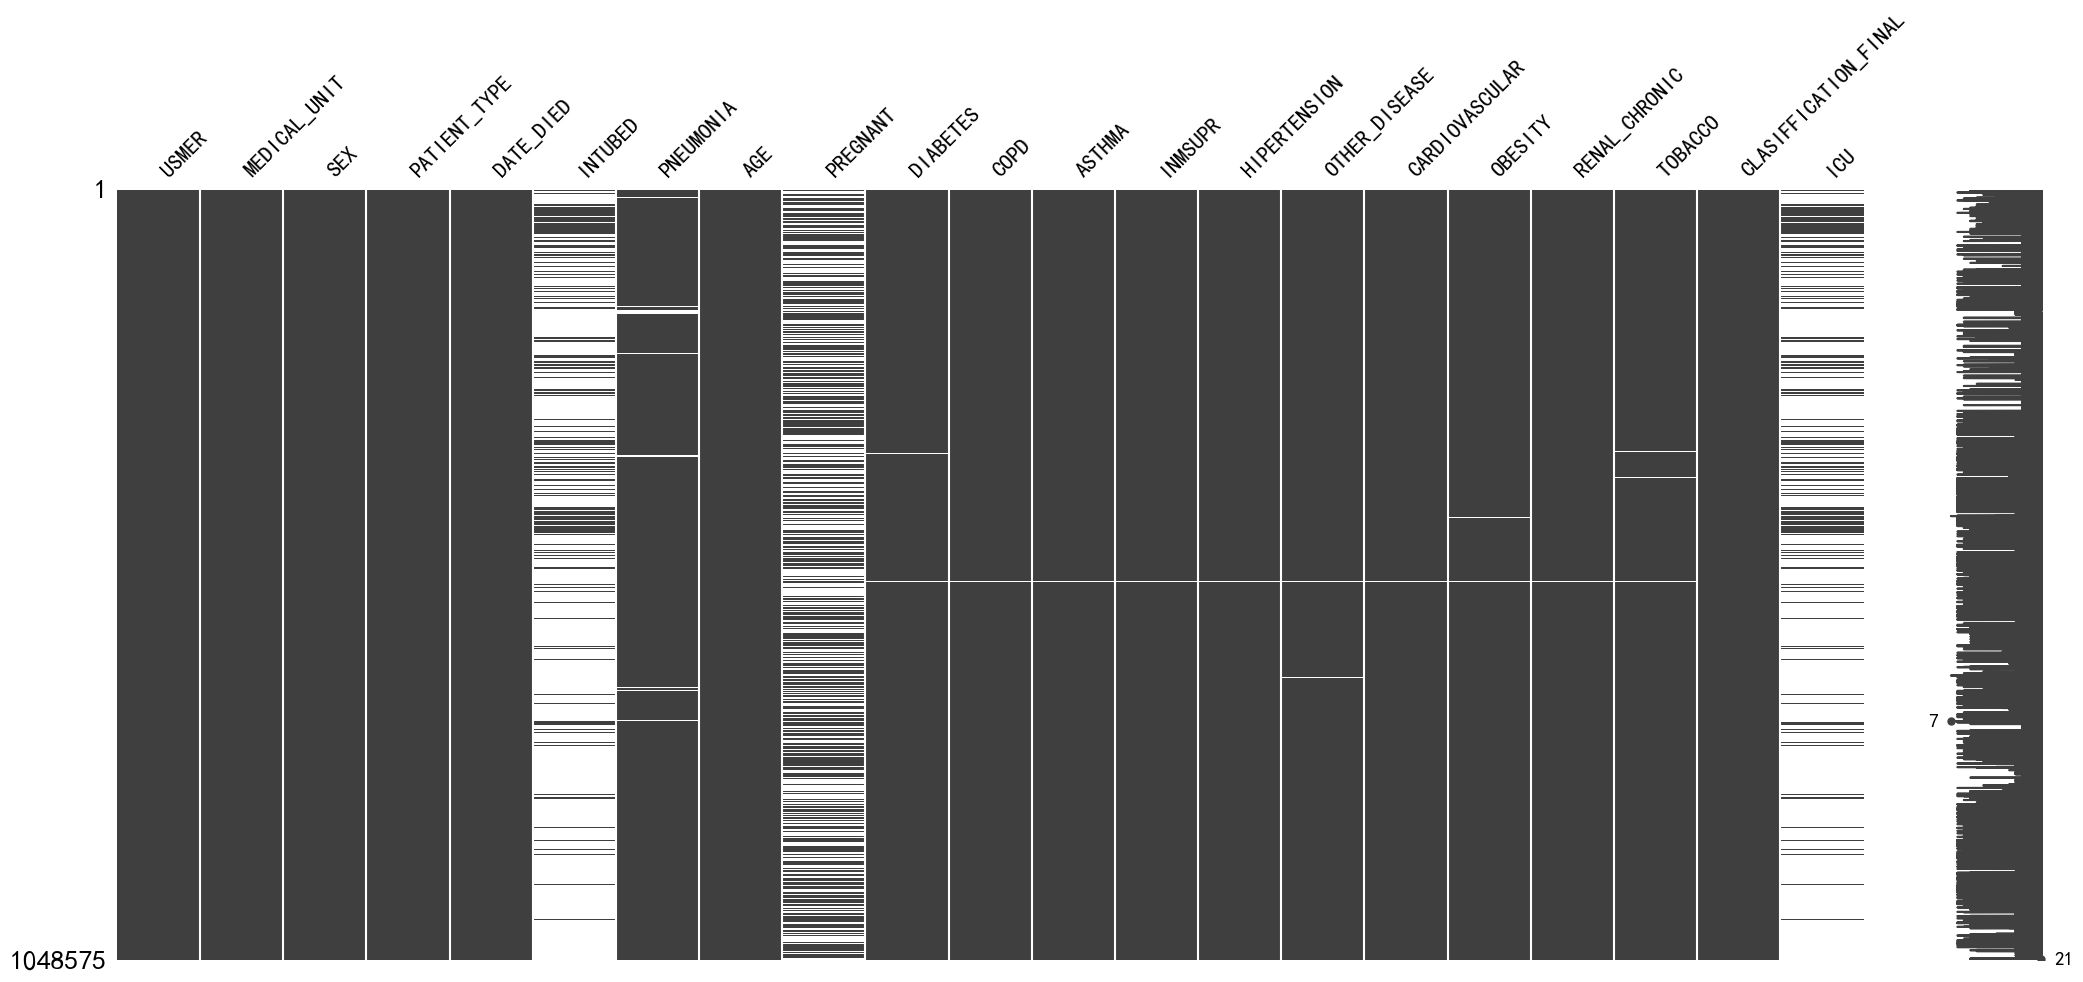

In [4]:
#缺失值描述矩阵图
msno.matrix(df)

<AxesSubplot:>

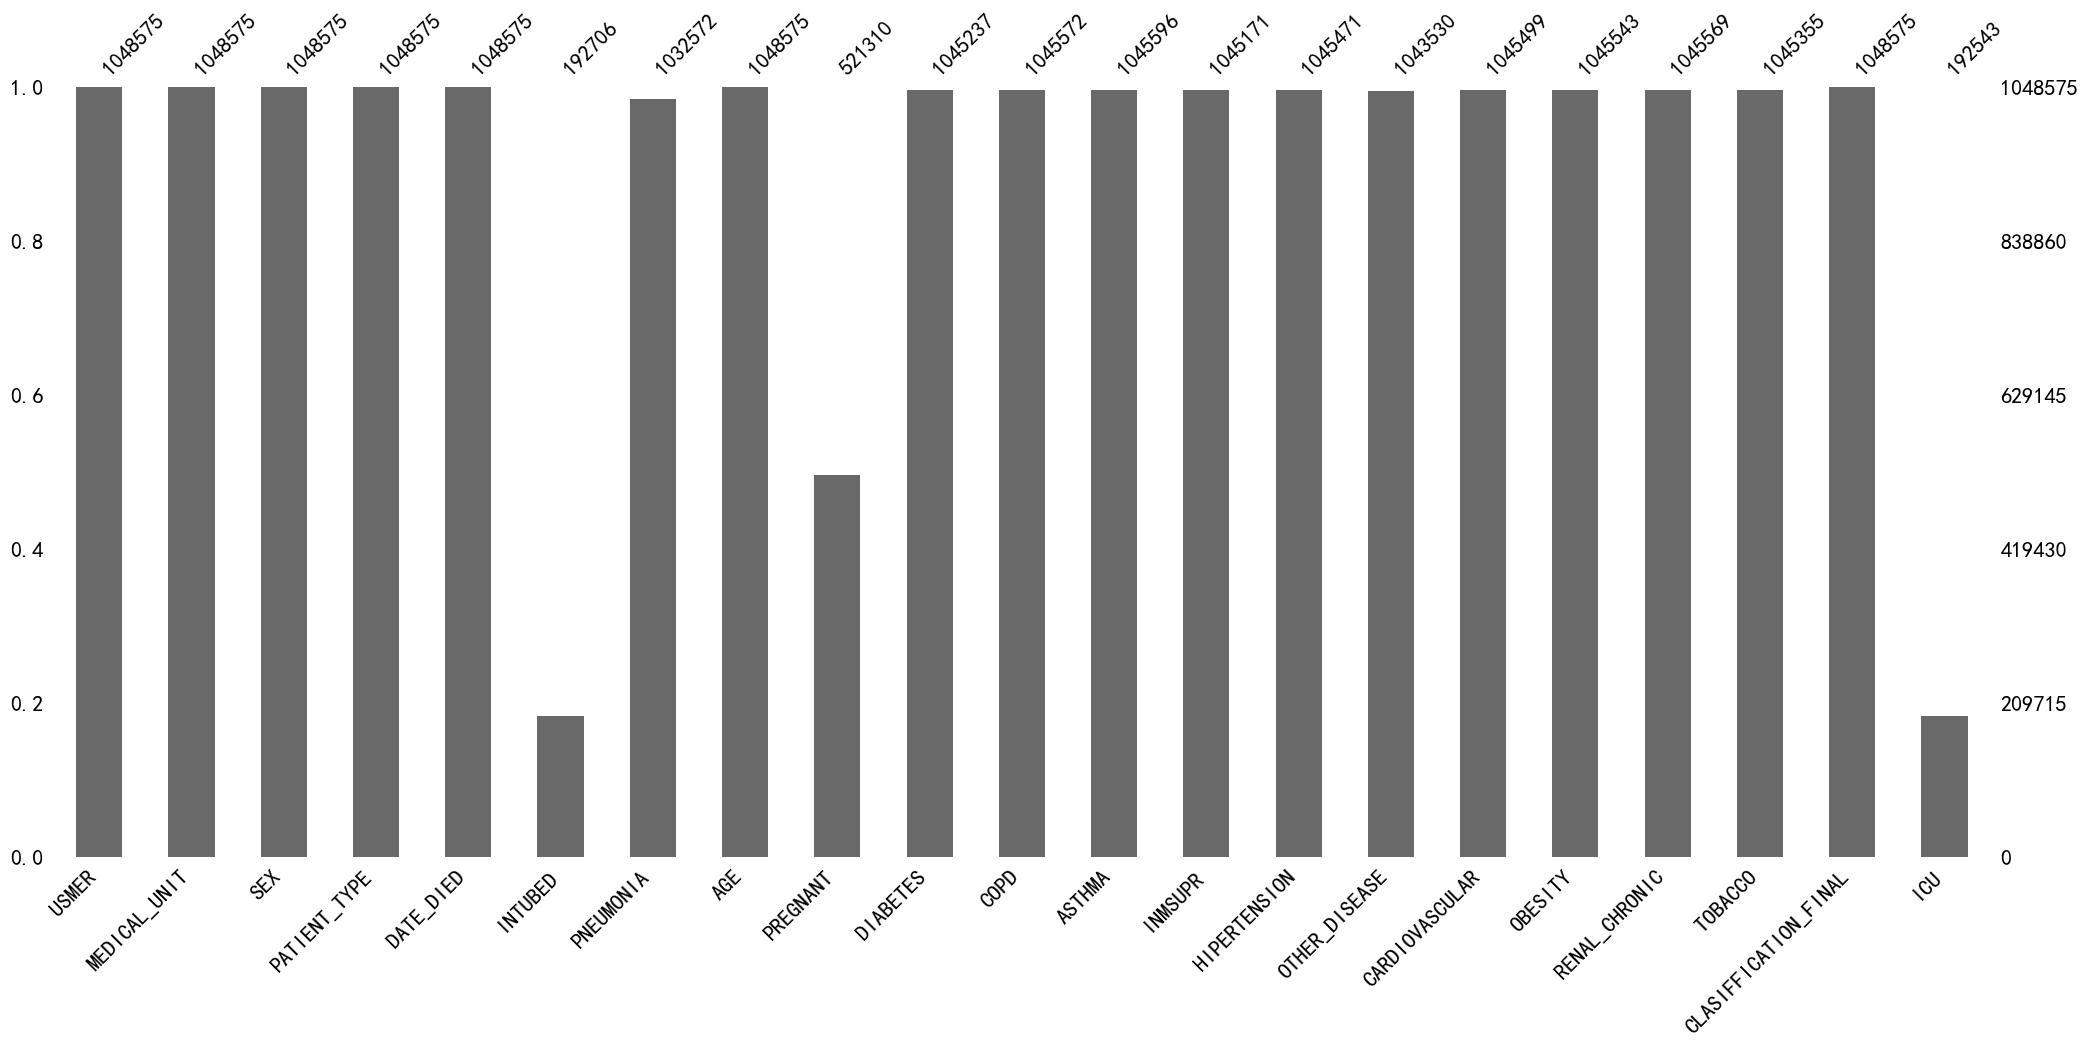

In [5]:
#缺失值柱状图
msno.bar(df)

In [9]:
# 将pregnant填补一下，如果是sex为0的话就不可能pregnant。
df.loc[df['SEX'] == 0,'PREGNANT'] = 0

# 构建我们的数据预测目标——是否死亡，如果一个人已经死了，就是有日期的，没死就是9999-99-99，
# 如果一个人被预测为快要死亡，那么说明他已经高危了，需要进行立即治疗

# 该值为病人是否死亡
df["DEATH"] = [0 if each=="9999-99-99" else 1 for each in df.DATE_DIED]
df.drop(["DATE_DIED"], axis=1, inplace=True)

# 删除缺失值较多的特征
df.drop(['INTUBED','ICU'], axis=1, inplace = True)

<AxesSubplot:>

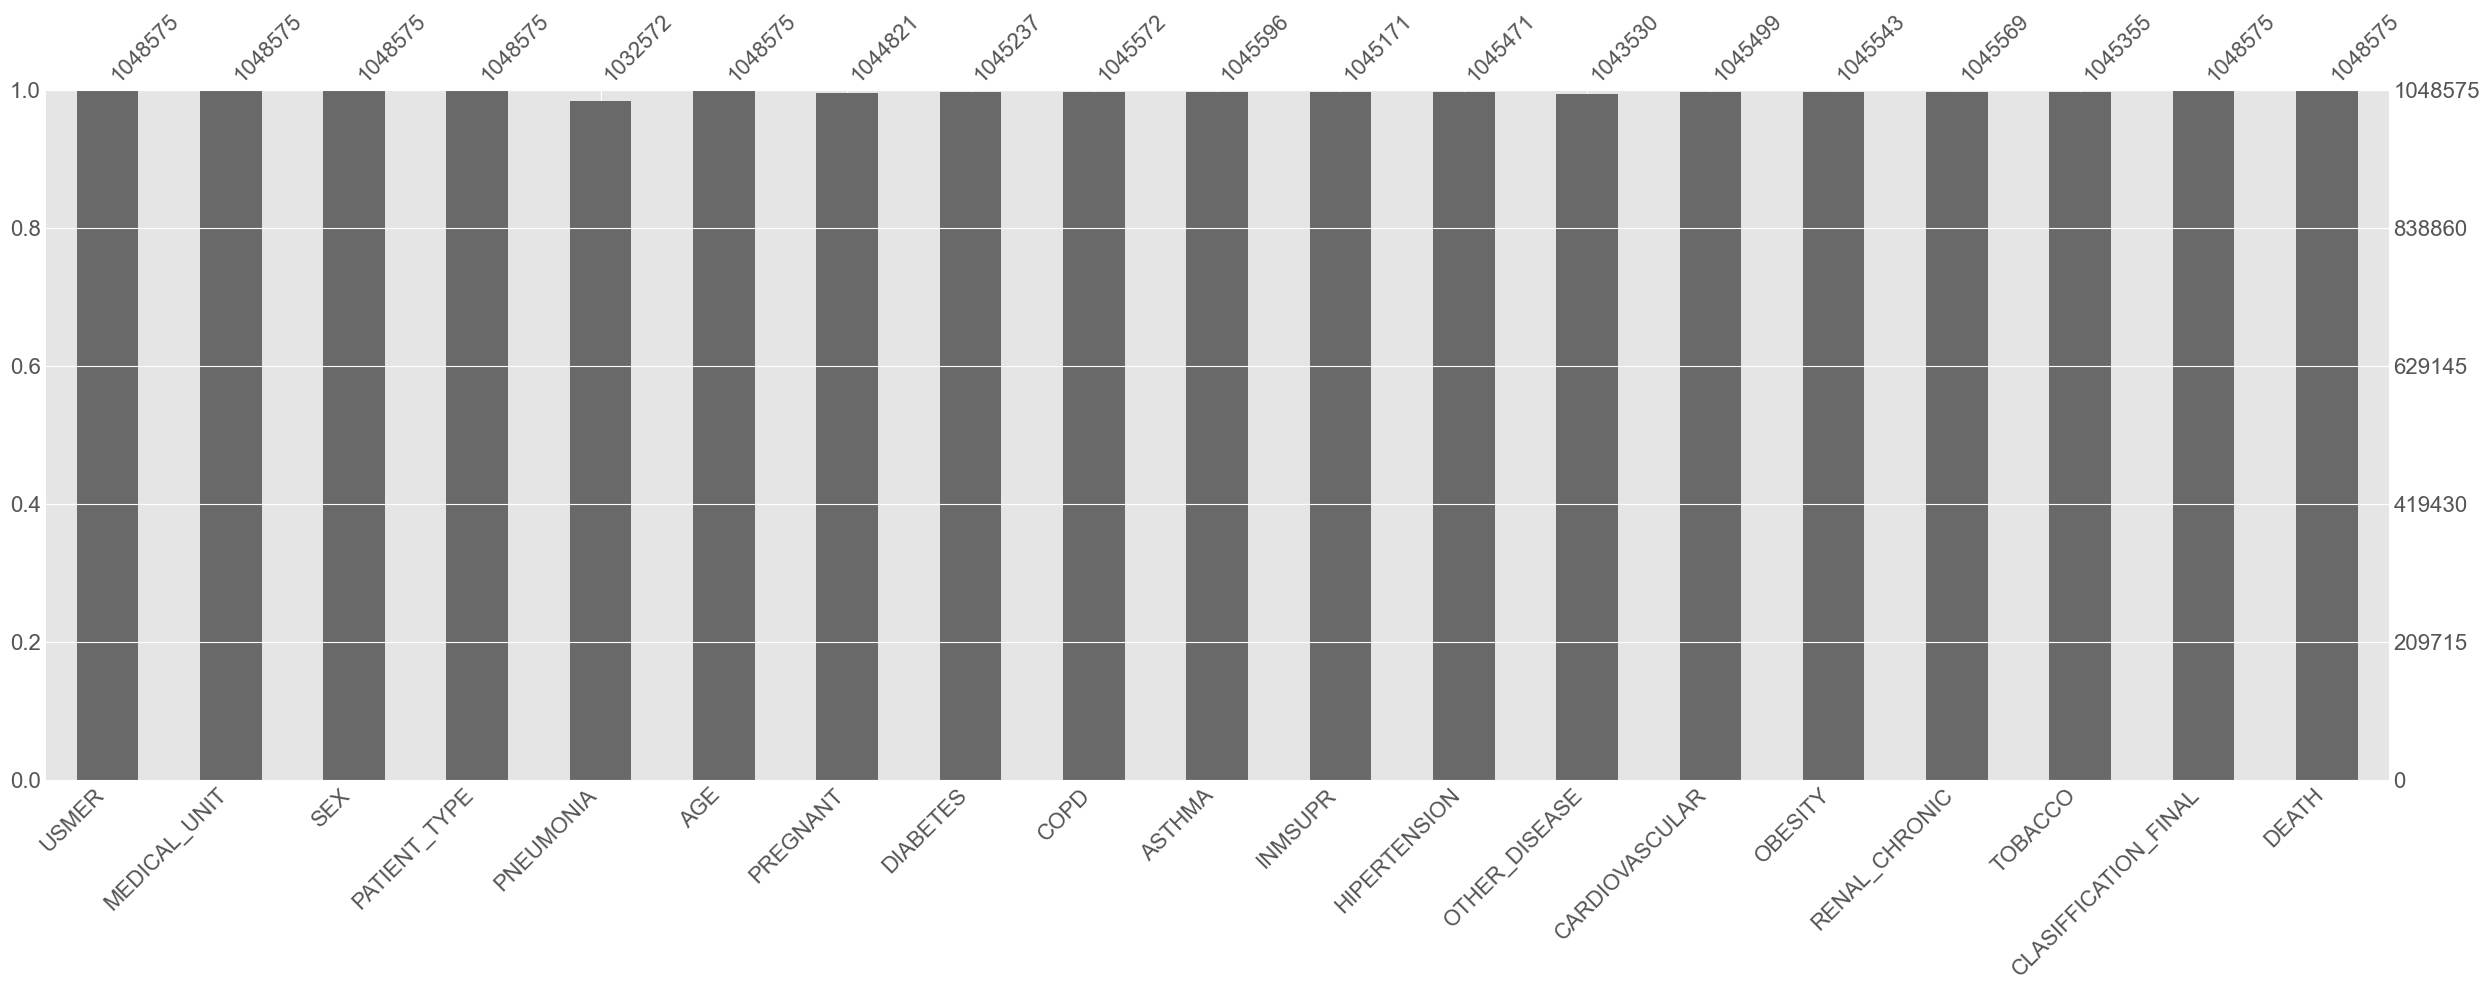

In [40]:
#缺失值柱状图
msno.bar(df)

In [10]:
# 查看数据分布
#对于数值型变量
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
USMER,0.367806,0.482208,0.0,0.0,0.0,1.0,1.0
MEDICAL_UNIT,8.980565,3.723278,1.0,4.0,12.0,12.0,13.0
SEX,0.500741,0.500000,0.0,0.0,1.0,1.0,1.0
PATIENT_TYPE,0.809235,0.392904,0.0,1.0,1.0,1.0,1.0
PNEUMONIA,0.135621,0.342385,0.0,0.0,0.0,0.0,1.0
AGE,41.794102,16.907389,0.0,30.0,40.0,53.0,121.0
PREGNANT,0.007782,0.087873,0.0,0.0,0.0,0.0,1.0
DIABETES,0.119580,0.324469,0.0,0.0,0.0,0.0,1.0
COPD,0.014406,0.119155,0.0,0.0,0.0,0.0,1.0
ASTHMA,0.030195,0.171124,0.0,0.0,0.0,0.0,1.0


In [11]:
# 少量缺失值的填补

# 找出具有缺失值的列
columns_with_missing_values = df.columns[df.isnull().any()]

# 逐列填补缺失值为众数
for column in columns_with_missing_values:
    mode_value = df[column].mode()[0]  # 计算众数
    df[column].fillna(mode_value, inplace=True)  # 使用众数填补缺失值

In [12]:
if df.isnull().sum().sum() == 0:
    print('缺失值已经全部处理完毕')
else:
    print('仍有缺失值')

缺失值已经全部处理完毕


#### 2.2异常值处理

In [44]:
# 此处先省略，因为模型数据量很大，因此运行时间过长，可以先不分析这部分
'''
from sklearn.ensemble import IsolationForest

# 创建孤立森林模型
isolation_forest = IsolationForest(contamination='auto')  # 可调整 contamination 参数

# 训练孤立森林模型
isolation_forest.fit(df)

# 预测异常值
outlier_predictions = isolation_forest.predict(df)

# 根据预测结果判断异常值
outlier_indices = outlier_predictions == -1

# 删除异常行
df_cleaned = df[~outlier_indices]

# 打印清洗后的数据集
print(df_cleaned)
'''

"\nfrom sklearn.ensemble import IsolationForest\n\n# 创建孤立森林模型\nisolation_forest = IsolationForest(contamination='auto')  # 可调整 contamination 参数\n\n# 训练孤立森林模型\nisolation_forest.fit(df)\n\n# 预测异常值\noutlier_predictions = isolation_forest.predict(df)\n\n# 根据预测结果判断异常值\noutlier_indices = outlier_predictions == -1\n\n# 删除异常行\ndf_cleaned = df[~outlier_indices]\n\n# 打印清洗后的数据集\nprint(df_cleaned)\n"

In [45]:
# 打印清洗后的数据集维度
# print(df_cleaned.shape)

### 3.可视化分析

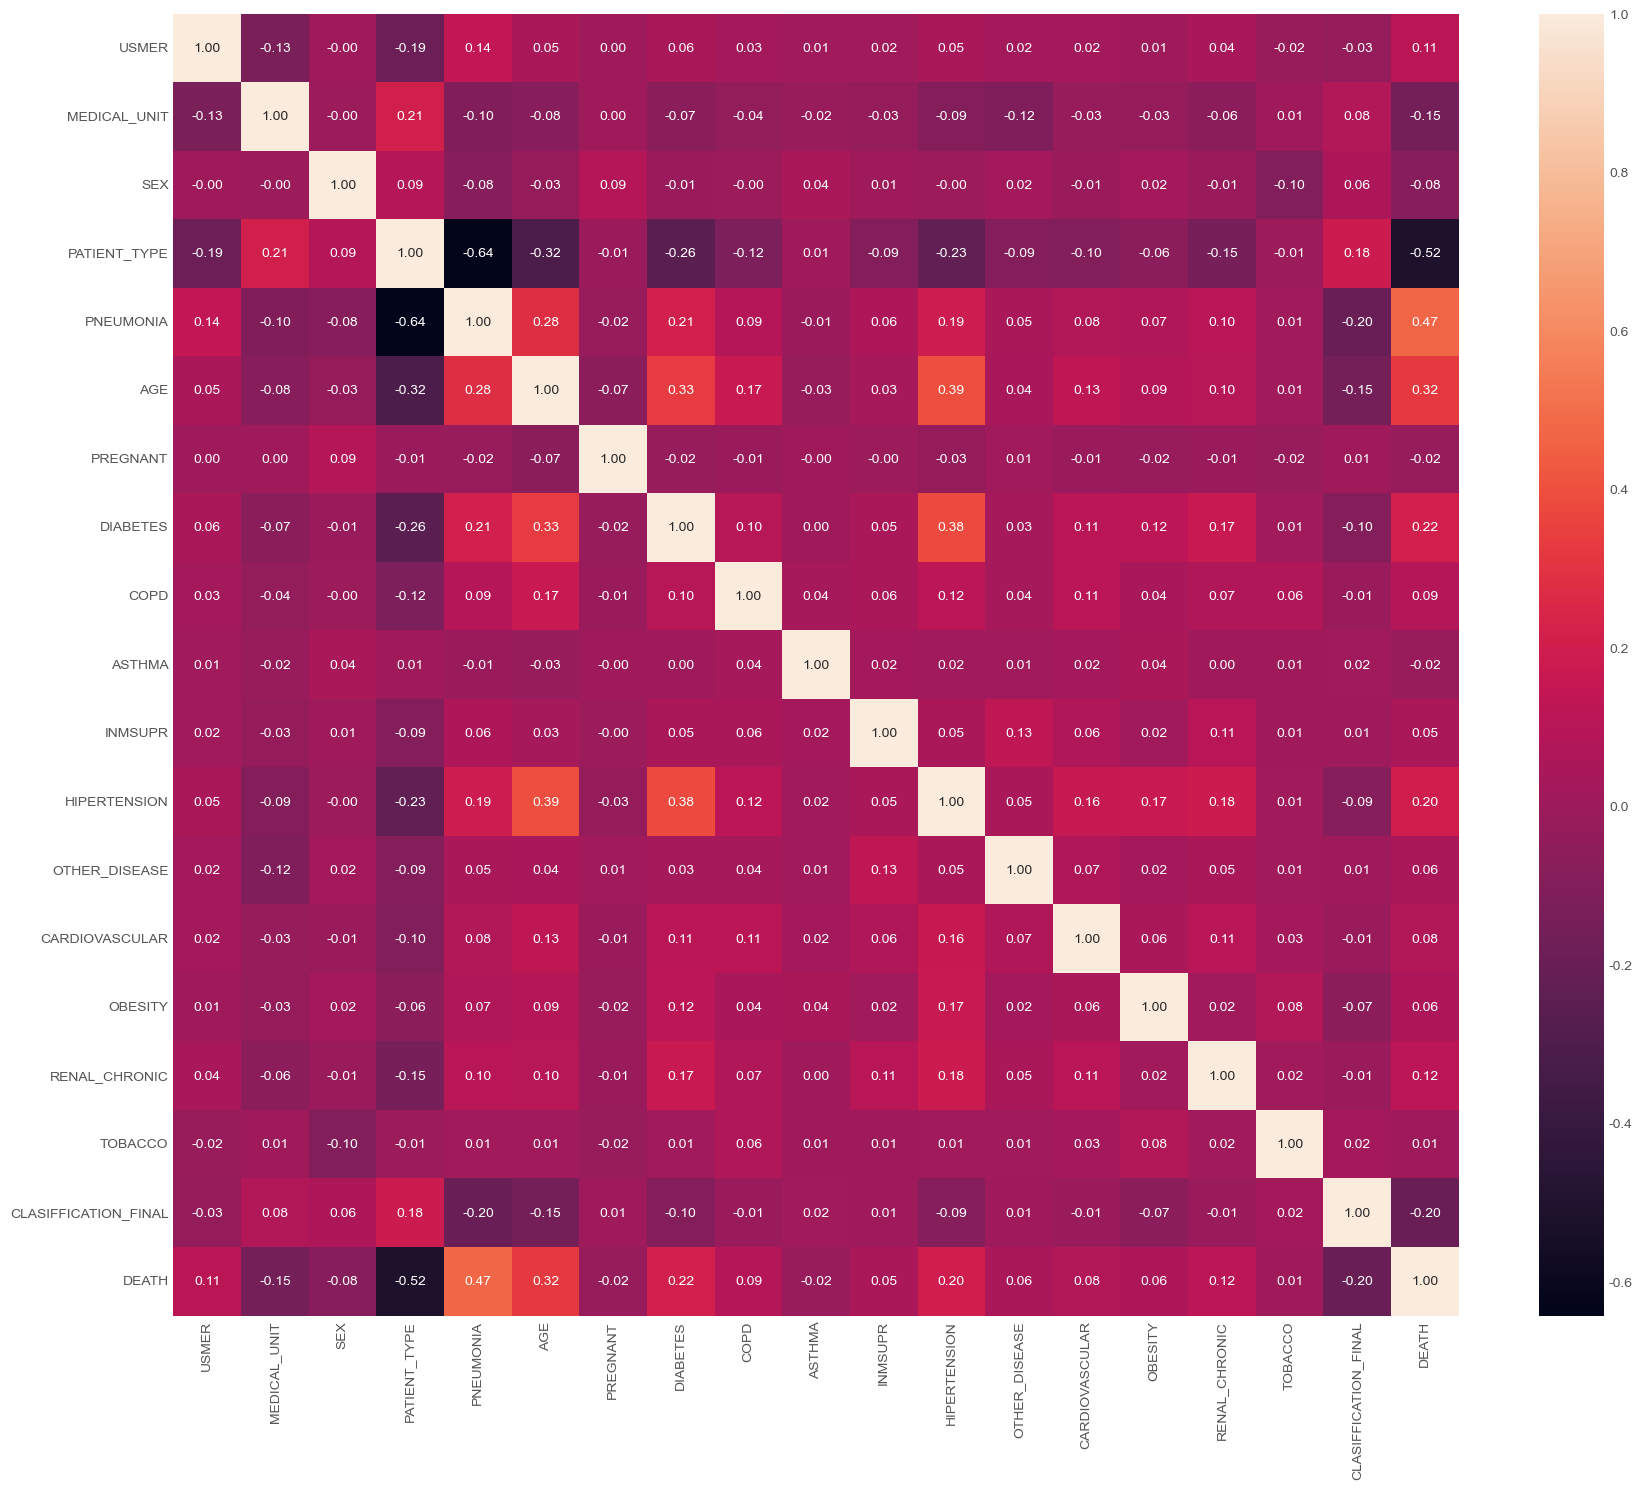

In [46]:
# 相关性分析
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(),annot=True, fmt=".2f")
#plt.title("Correlation Between Features",fontsize=18,color="red")
plt.savefig('pic/Correlation Between Features.png',dpi=600)
# 可以发现各特征之间的相关性都较弱

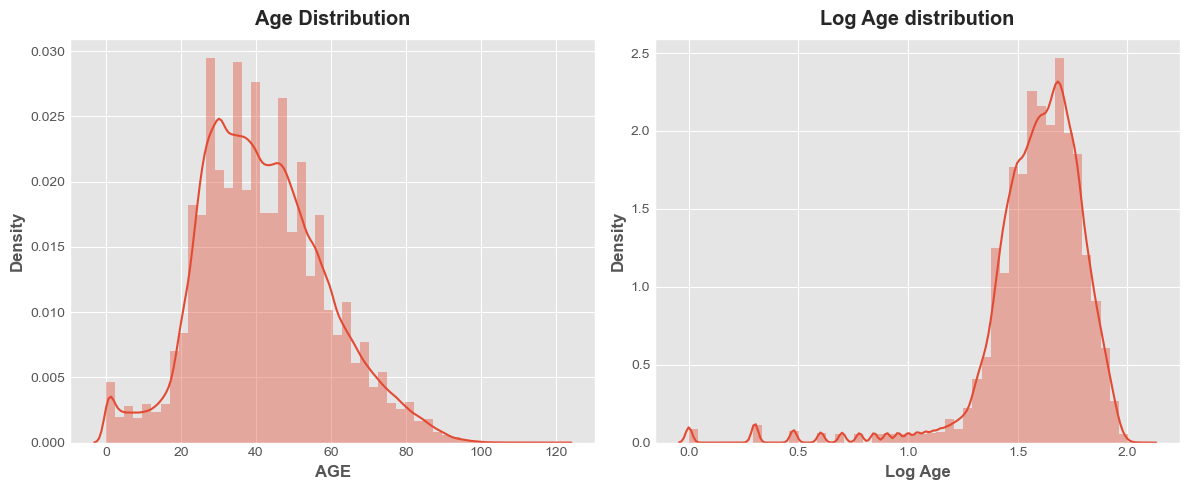

In [47]:
#单变量分析——主要针对变量Age的分析
f, ax = plt.subplots(1,2,figsize=(12,5), sharey=False)
sns.distplot(df["AGE"], ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_xlabel("AGE")
ax[0].set_ylabel("Density")
sns.distplot(np.log10((df["AGE"][df["AGE"].notnull()]+1)), ax=ax[1])
ax[1].set_title("Log Age distribution")
ax[1].set_xlabel("Log Age")
ax[1].set_ylabel("Density")
plt.tight_layout()
plt.savefig('pic/Age Distribution.png',dpi=600)

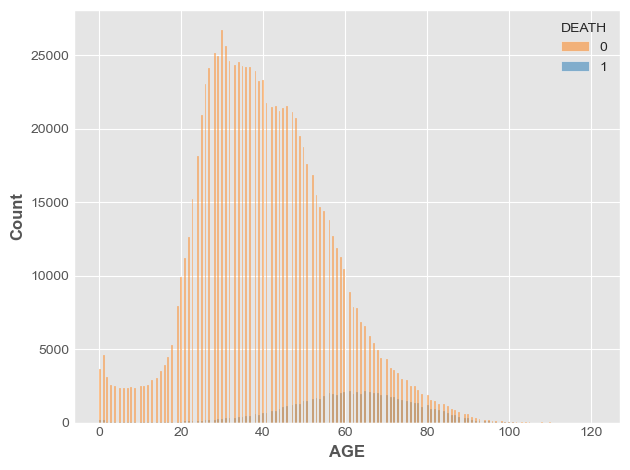

In [48]:
# 年龄与死亡直方图
sns.histplot(x=df.AGE,hue = df.DEATH, palette=sns.color_palette(["#ff7f0e", "#1f77b4"]))
#plt.title("Age Distribution", color="red", fontsize=18)
plt.savefig('pic/DEATH_AGE_hist_RELATION.png',dpi=600)

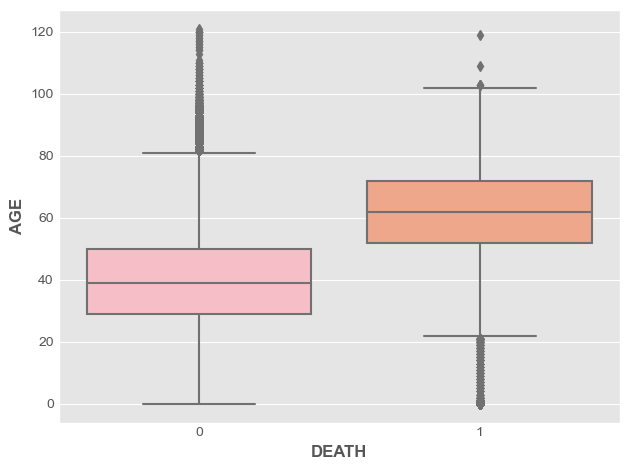

In [49]:
# 年龄与死亡箱线图
sns.boxplot(x="DEATH", y="AGE",data=df,palette=sns.color_palette(["#FFB6C1", "#FFA07A"]))
#plt.title("AGE-DEATH",fontsize=15)
plt.savefig('pic/DEATH_AGE_RELATION.png',dpi=600)

In [13]:
import pandas as pd
from scipy.stats import f_oneway

# 执行方差分析
f_value, p_value = f_oneway(df['AGE'], df['DEATH'])

# 输出结果
print('F-value:', f_value)
print('P-value:', p_value)

F-value: 6383322.713190288
P-value: 0.0


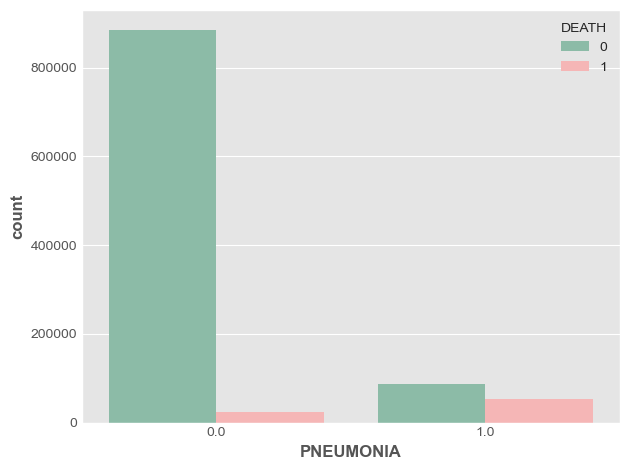

In [51]:
# 肺炎与死亡关系
sns.countplot(data=df, x='PNEUMONIA', hue='DEATH',palette=sns.color_palette(["#84C3A8", "#FFACAC"]))
# plt.title("PNEUMONIA-DEATH",fontsize=15)
plt.savefig('pic/DEATH_PNEUMONIA_RELATION.png',dpi=600)

In [52]:
import pandas as pd
from scipy.stats import f_oneway

# 执行方差分析
f_value, p_value = f_oneway(df['PNEUMONIA'], df['DEATH'])

# 输出结果
print('F-value:', f_value)
print('P-value:', p_value)

F-value: 20666.875653831008
P-value: 0.0


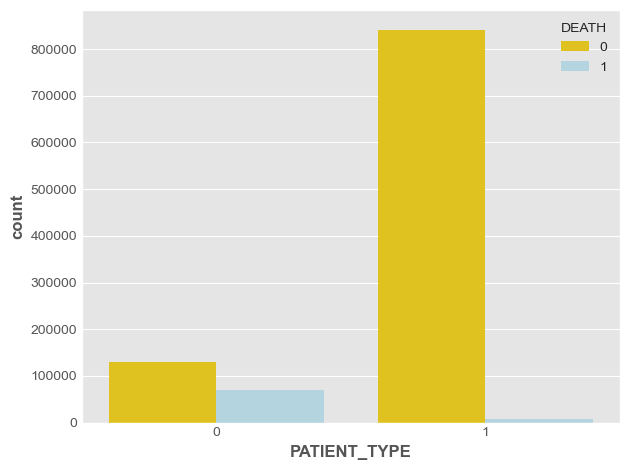

In [53]:
# 患者类型与死亡关系
sns.countplot(data=df, x='PATIENT_TYPE', hue='DEATH',palette=sns.color_palette(["#FFD700", "#ADD8E6"]))
# plt.title("PATIENT_TYPE-DEATH",fontsize=15)
plt.savefig('pic/DEATH_PATIENT_TYPE_RELATION.png',dpi=600)

In [54]:
import pandas as pd
from scipy.stats import f_oneway

# 执行方差分析
f_value, p_value = f_oneway(df['PATIENT_TYPE'], df['DEATH'])

# 输出结果
print('F-value:', f_value)
print('P-value:', p_value)

F-value: 2553387.312213208
P-value: 0.0


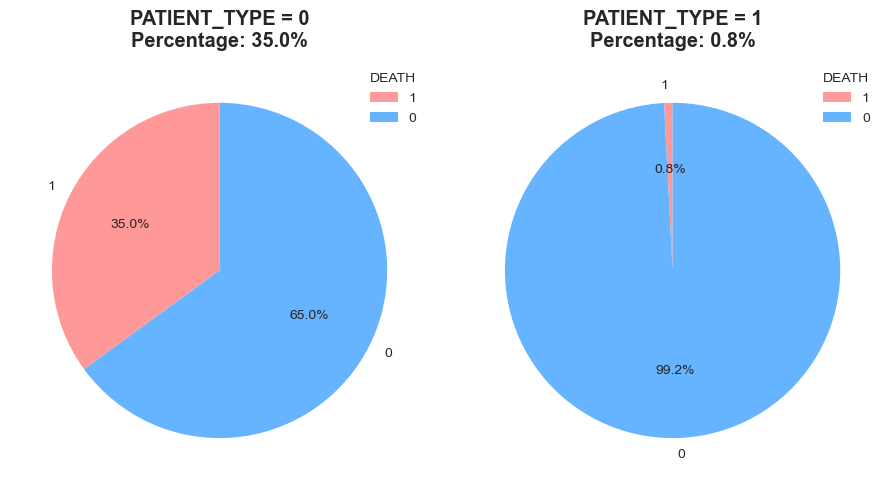

In [55]:
# 患者类型（在医院或不在医院）与死亡的关系

patient_type_0_death_1_count = len(df.loc[(df['PATIENT_TYPE'] == 0) & (df['DEATH'] == 1)])
patient_type_0_count = len(df.loc[df['PATIENT_TYPE'] == 0])
percentage1  = (patient_type_0_death_1_count/patient_type_0_count) * 100

patient_type_1_death_1_count = len(df.loc[(df['PATIENT_TYPE'] == 1) & (df['DEATH'] == 1)])
patient_type_1_count = len(df.loc[df['PATIENT_TYPE'] == 1])
percentage2  = (patient_type_1_death_1_count/patient_type_1_count) * 100

# 创建画布和子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 自定义颜色和透明度
colors = ['#ff9999', '#66b3ff']  # 使用两种常见的柔和色调和50%透明度

# 绘制 PATIENT_TYPE 为 0 的饼图
ax1.pie([patient_type_0_death_1_count, patient_type_0_count - patient_type_0_death_1_count], labels=['1', '0'], autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('PATIENT_TYPE = 0\nPercentage: {:.1f}%'.format(percentage1))
ax1.set_alpha(0.7)  # 设置透明度为0.7
ax1.legend(title='DEATH', loc='upper right')

# 绘制 PATIENT_TYPE 为 1 的饼图
ax2.pie([patient_type_1_death_1_count, patient_type_1_count - patient_type_1_death_1_count], labels=['1', '0'], autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('PATIENT_TYPE = 1\nPercentage: {:.1f}%'.format(percentage2))
ax2.set_alpha(0.7)  # 设置透明度为0.7
ax2.legend(title='DEATH', loc='upper right')

# 展示饼图
plt.savefig('pic/DEATH_PATIENT_TYPE_PIE_RELATION.png',dpi=600)
plt.show()

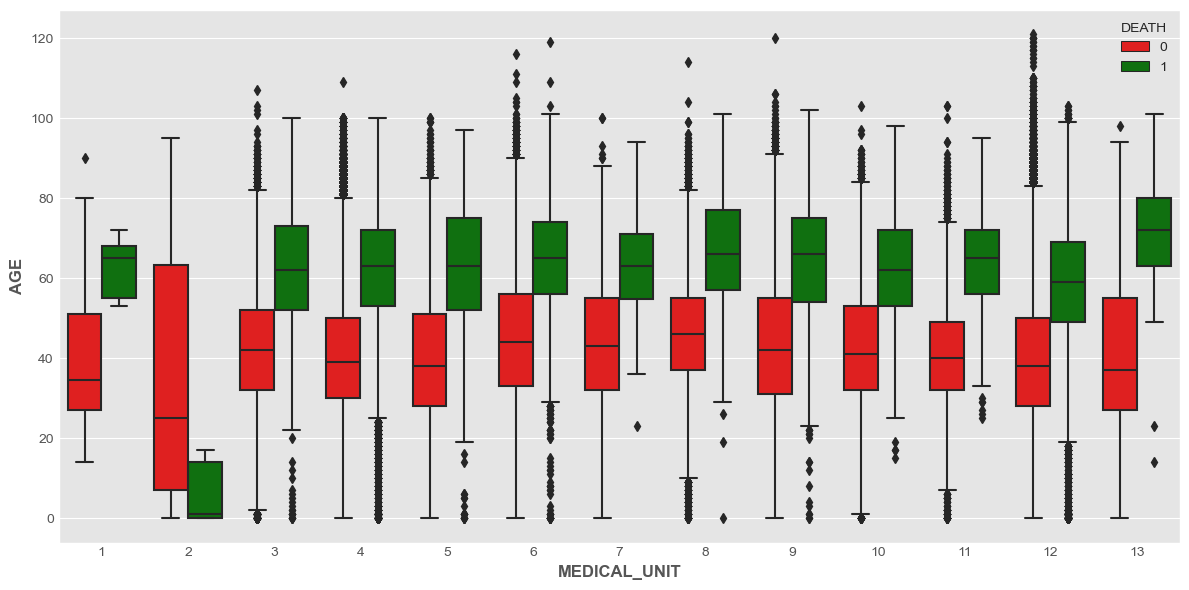

In [56]:
# Distribution of patients who went to medical units by age
plt.figure(figsize=(12,6))
sns.boxplot(x=df['MEDICAL_UNIT'],y=df.AGE,hue=df['DEATH'],palette=["red","green"])
plt.savefig('pic/Distribution of patients who went to medical units by age.png',dpi=600)

### 4.特征提取

#### 4.1标准化

In [14]:
# Z-score标准化
def z_score(df, cols):
    # df是数据框，cols是要标准化的列名列表
    for col in cols:
        # 计算每列的均值和标准差
        mean = df[col].mean()
        std = df[col].std()
        # 对每列进行标准化
        df[col] = (df[col] - mean) / std
    return df

#标准化
df = z_score(df,['AGE'])

#### 4.2哑变量处理

In [15]:
df = pd.get_dummies(df,columns=["MEDICAL_UNIT","CLASIFFICATION_FINAL"],drop_first=True)

#### 4.3类别不平衡处理

In [16]:
df.DEATH.value_counts()

0    971633
1     76942
Name: DEATH, dtype: int64

In [17]:
# 假设目标变量为'y'，特征变量为'X'
X = df.drop('DEATH', axis=1)
y = df['DEATH']

In [18]:
# 采用下采样的方式解决类别不平衡
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
x_resampled,y_resampled = rus.fit_resample(X,y)

print(x_resampled.shape)
print(y_resampled.shape)

(153884, 34)
(153884,)


Text(0.5, 1.0, 'Correlation Between Features')

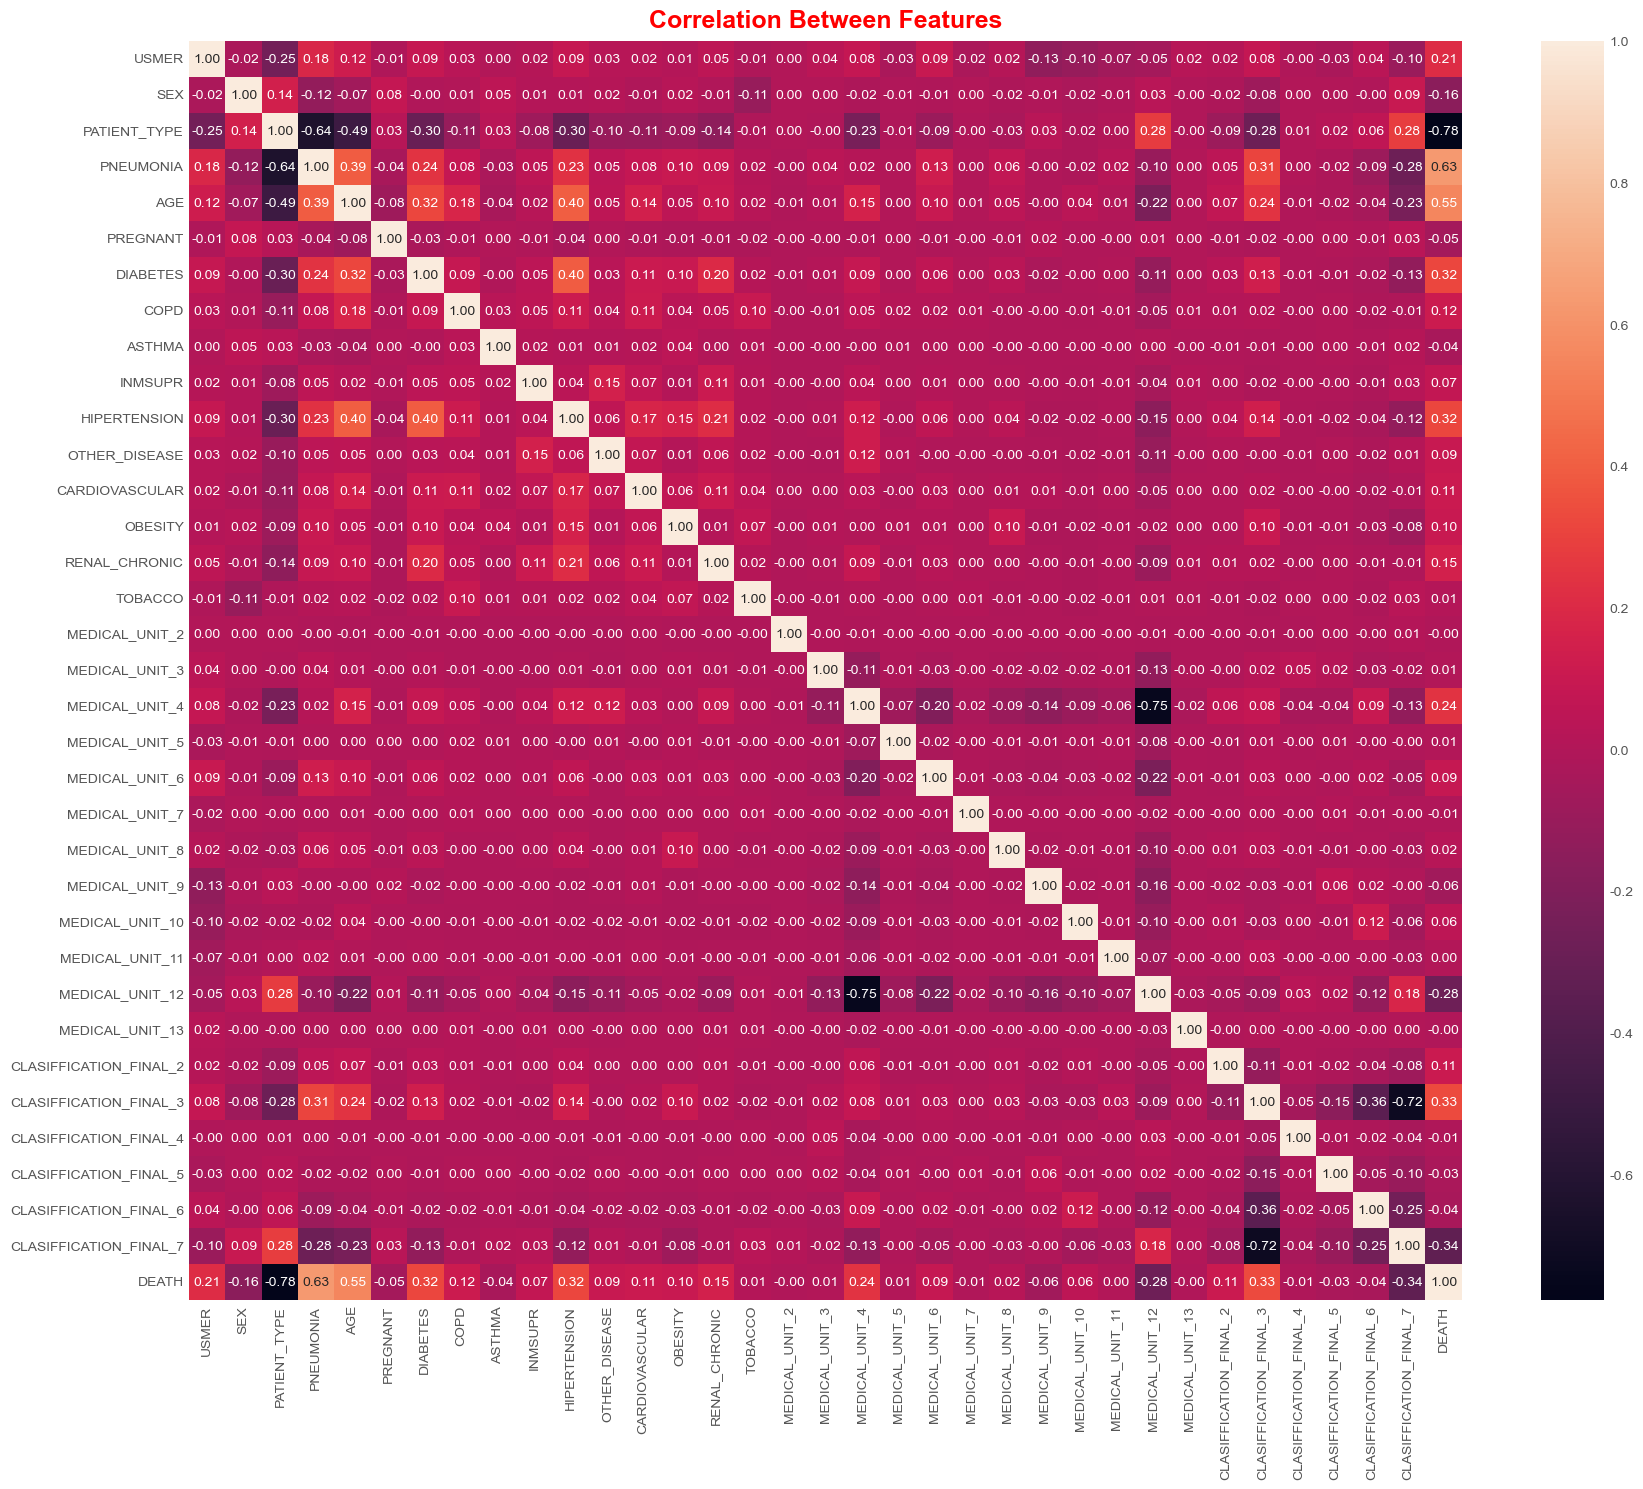

In [79]:
# 下采样后的相关性检测
df_new = pd.concat([x_resampled, y_resampled], axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(df_new.corr(),annot=True, fmt=".2f")
plt.title("Correlation Between Features",fontsize=18,color="red")

In [26]:
#上采样方式

from imblearn.over_sampling import SMOTE

# 创建SMOTE对象
smote = SMOTE(k_neighbors=5, random_state=0)

# 进行上采样
x_resampled2, y_resampled2 = smote.fit_resample(X, y)

print(x_resampled2.shape)
print(y_resampled2.shape)


(1943266, 34)
(1943266,)


Text(0.5, 1.0, 'Correlation Between Features')

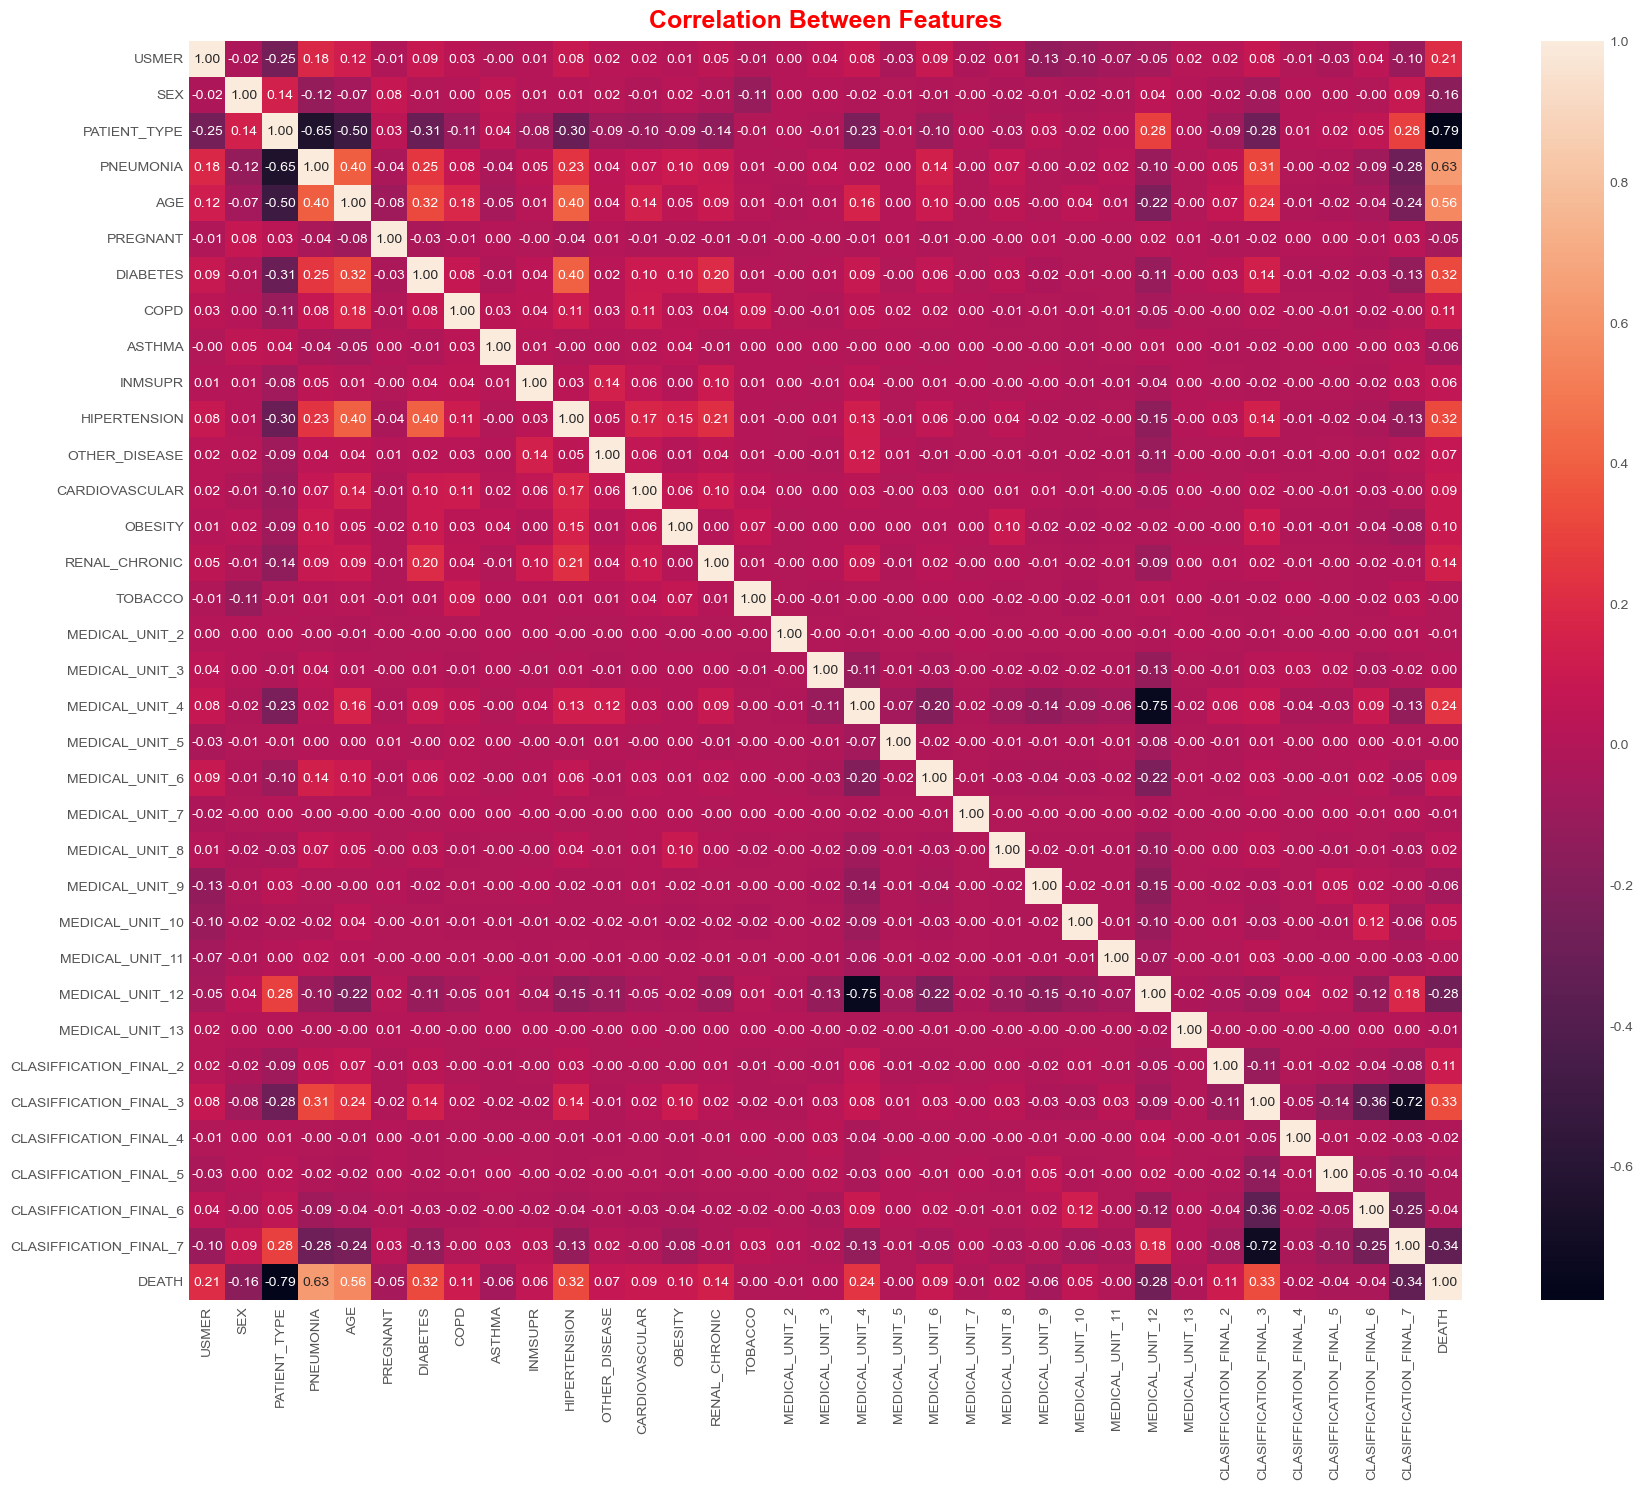

In [35]:
# 上采样后的相关性检测
df_new = pd.concat([x_resampled2, y_resampled2], axis=1)
plt.figure(figsize=(18,15))
sns.heatmap(df_new.corr(),annot=True, fmt=".2f")
plt.title("Correlation Between Features",fontsize=18,color="red")

#### 4.4数据泄露处理

In [19]:
# 删除PATIENT_TYPE这一变量
x_resampled.drop(['PATIENT_TYPE'],axis = 1,inplace = True)

### 5.机器学习算法

#### 5.1 导入库

In [20]:
# 导入相关库
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

#### 5.2 划分数据集

In [21]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
# 如果是对原数据集，请改为X,y
# 如果是使用上采样方式，请改为x_resampled2, y_resampled2

#### 5.3 应用模型方法

In [22]:
import time

In [23]:
# 逻辑回归
logistic_model = LogisticRegression()
log_train_s = time.time()
logistic_model.fit(X_train, y_train)
log_train_e = time.time()
log_test_s = time.time()
logistic_predictions = logistic_model.predict(X_test)
log_test_e = time.time()
logistic_report = classification_report(y_test, logistic_predictions)
logistic_train_accuracy = accuracy_score(y_train, logistic_model.predict(X_train))
logistic_test_accuracy = accuracy_score(y_test, logistic_predictions)
print("逻辑回归分类报告:")
print(logistic_report)
print("逻辑回归训练集准确率:", logistic_train_accuracy)
print("逻辑回归测试集准确率:", logistic_test_accuracy)

逻辑回归分类报告:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     15296
           1       0.88      0.88      0.88     15481

    accuracy                           0.88     30777
   macro avg       0.88      0.88      0.88     30777
weighted avg       0.88      0.88      0.88     30777

逻辑回归训练集准确率: 0.877578041866019
逻辑回归测试集准确率: 0.8789030769730644


In [24]:
# 决策树
tree_model = DecisionTreeClassifier(max_depth = 10 ,min_samples_split = 10)
dt_train_s = time.time()
tree_model.fit(X_train, y_train)
dt_train_e = time.time()
dt_test_s = time.time()
tree_predictions = tree_model.predict(X_test)
dt_test_e = time.time()
tree_report = classification_report(y_test, tree_predictions)
tree_train_accuracy = accuracy_score(y_train, tree_model.predict(X_train))
tree_test_accuracy = accuracy_score(y_test, tree_predictions)
print("决策树分类报告:")
print(tree_report)
print("决策树训练集准确率:", tree_train_accuracy)
print("决策树测试集准确率:", tree_test_accuracy)

决策树分类报告:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     15296
           1       0.86      0.90      0.88     15481

    accuracy                           0.88     30777
   macro avg       0.88      0.88      0.88     30777
weighted avg       0.88      0.88      0.88     30777

决策树训练集准确率: 0.8876099653147262
决策树测试集准确率: 0.8790330441563505


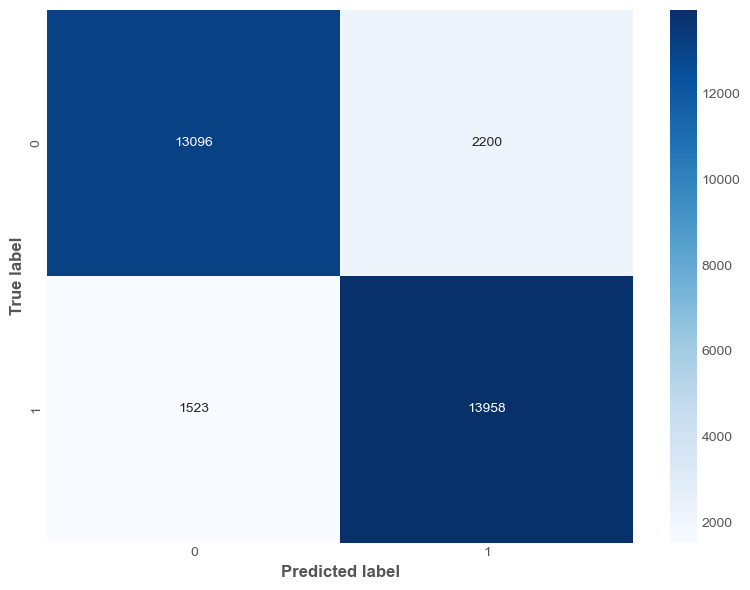

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


# 示例数据
y_true = y_test
y_pred = tree_predictions

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('./pic/confusion_matrix.png',dpi = 500)
plt.show()


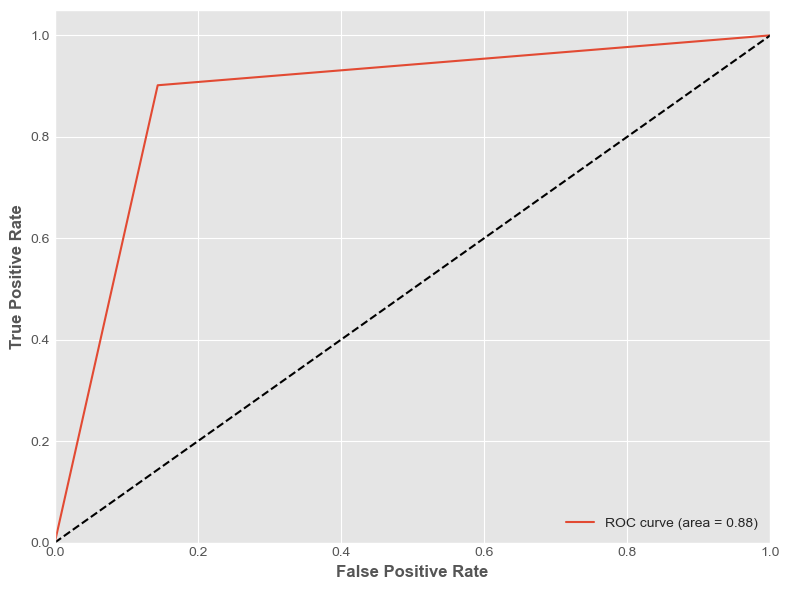

In [26]:
# 生成ROC曲线
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('./pic/ROC.png',dpi = 500)
plt.show()

In [46]:
import graphviz
from sklearn import tree
import os  # 以代码手动进行环境变量配置，防止在本机环境的变量部署失败
os.environ['PATH'] = os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

# 可视化决策树模型
dot_data = tree.export_graphviz(tree_model, out_file=None, feature_names=X_train.columns, max_depth=3)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # 可选步骤，将决策树保存为PDF或图像文件
graph.view()  # 在默认图形查看器中显示决策树

'decision_tree.pdf'

In [27]:
# 决策树特征重要性
df_importances = pd.DataFrame(list(x_resampled), tree_model.feature_importances_)
df_importances.columns = ["Feature_Names"]
df_importances["Importances"] = df_importances.index
df_importances = df_importances.sort_values(by = "Importances", ascending = False)
df_importances.index = np.arange(0,len(df_importances))
df_importances

,Feature_Names,Importances
0,PNEUMONIA,0.597715
1,AGE,0.226516
2,MEDICAL_UNIT_4,0.087328
3,CLASIFFICATION_FINAL_7,0.013365
4,MEDICAL_UNIT_10,0.012854
5,DIABETES,0.010149
6,RENAL_CHRONIC,0.007912
7,SEX,0.007710
8,USMER,0.006814
9,CLASIFFICATION_FINAL_2,0.003885


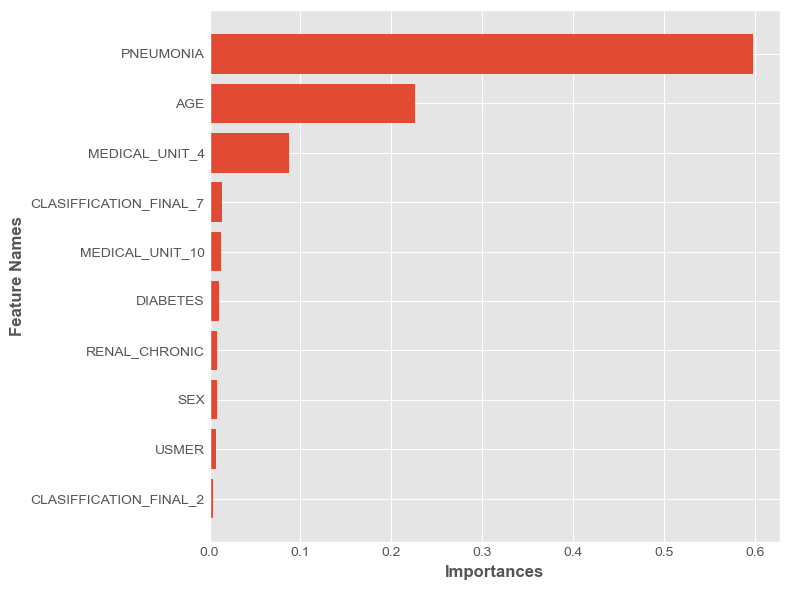

In [28]:
# 取前十个特征并逆序排列
df_top10 = df_importances.head(10)[::-1]

# 绘制横向柱状图
plt.figure(figsize=(8, 6))
plt.barh(df_top10["Feature_Names"], df_top10["Importances"])
plt.xlabel('Importances')
plt.ylabel('Feature Names')
plt.savefig('./pic/fefature_importance.png',dpi = 500)
plt.show()

In [29]:
# LightGBM分类器
lgb_model = lgb.LGBMClassifier()
lbm_train_s = time.time()
lgb_model.fit(X_train, y_train)
lbm_train_e = time.time()
lgb_pred_train = lgb_model.predict(X_train)
lbm_test_s = time.time()
lgb_pred_test = lgb_model.predict(X_test)
lbm_test_e = time.time()
lgb_acc_train = accuracy_score(y_train, lgb_pred_train)
lgb_acc_test = accuracy_score(y_test, lgb_pred_test)
print("LightGBM Training Accuracy:", lgb_acc_train)
print("LightGBM Test Accuracy:", lgb_acc_test)
print("LightGBM Classification Report:")
print(classification_report(y_test, lgb_pred_test))

LightGBM Training Accuracy: 0.8871063383885563
LightGBM Test Accuracy: 0.8835494037755467
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     15296
           1       0.87      0.91      0.89     15481

    accuracy                           0.88     30777
   macro avg       0.88      0.88      0.88     30777
weighted avg       0.88      0.88      0.88     30777



In [19]:
# lightgbm特征重要性
df_importances = pd.DataFrame(list(x_resampled), lgb_model.feature_importances_)
df_importances.columns = ["Feature_Names"]
df_importances["Importances"] = df_importances.index
df_importances = df_importances.sort_values(by = "Importances", ascending = False)
df_importances.index = np.arange(0,len(df_importances))
df_importances

,Feature_Names,Importances
0,AGE,825
1,CLASIFFICATION_FINAL_7,146
2,SEX,145
3,DIABETES,135
4,USMER,132
5,PNEUMONIA,126
6,MEDICAL_UNIT_4,115
7,RENAL_CHRONIC,111
8,CLASIFFICATION_FINAL_2,98
9,INMSUPR,97


In [22]:
# XGBoost分类器
xgb_model = xgb.XGBClassifier()
xgb_train_s = time.time()
xgb_model.fit(X_train, y_train)
xgb_train_e = time.time()
xgb_pred_train = xgb_model.predict(X_train)
xgb_test_s = time.time()
xgb_pred_test = xgb_model.predict(X_test)
xgb_test_e = time.time()
xgb_acc_train = accuracy_score(y_train, xgb_pred_train)
xgb_acc_test = accuracy_score(y_test, xgb_pred_test)
print("XGBoost Training Accuracy:", xgb_acc_train)
print("XGBoost Test Accuracy:", xgb_acc_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred_test))

XGBoost Training Accuracy: 0.8909566474692747
XGBoost Test Accuracy: 0.8833219612047958
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     15296
           1       0.87      0.91      0.89     15481

    accuracy                           0.88     30777
   macro avg       0.88      0.88      0.88     30777
weighted avg       0.88      0.88      0.88     30777



In [21]:
# XGB特征重要性

df_importances = pd.DataFrame(list(x_resampled), xgb_model.feature_importances_)
df_importances.columns = ["Feature_Names"]
df_importances["Importances"] = df_importances.index
df_importances = df_importances.sort_values(by = "Importances", ascending = False)
df_importances.index = np.arange(0,len(df_importances))
df_importances

,Feature_Names,Importances
0,PNEUMONIA,0.521963
1,MEDICAL_UNIT_4,0.112225
2,MEDICAL_UNIT_12,0.051094
3,MEDICAL_UNIT_10,0.050802
4,CLASIFFICATION_FINAL_2,0.037201
5,AGE,0.035410
6,CLASIFFICATION_FINAL_7,0.025853
7,MEDICAL_UNIT_9,0.021767
8,RENAL_CHRONIC,0.017151
9,DIABETES,0.014669


In [23]:
# CatBoost分类器
cat_model = CatBoostClassifier()
cat_train_s = time.time()
cat_model.fit(X_train, y_train)
cat_train_e = time.time()
cat_pred_train = cat_model.predict(X_train)
cat_test_s = time.time()
cat_pred_test = cat_model.predict(X_test)
cat_test_e = time.time()
cat_acc_train = accuracy_score(y_train, cat_pred_train)
cat_acc_test = accuracy_score(y_test, cat_pred_test)
print("CatBoost Training Accuracy:", cat_acc_train)
print("CatBoost Test Accuracy:", cat_acc_test)
print("CatBoost Classification Report:")
print(classification_report(y_test, cat_pred_test))

Learning rate set to 0.080442
0:	learn: 0.6206646	total: 24.9ms	remaining: 24.9s
1:	learn: 0.5630127	total: 47.3ms	remaining: 23.6s
2:	learn: 0.5172792	total: 67.8ms	remaining: 22.5s
3:	learn: 0.4814593	total: 91.5ms	remaining: 22.8s
4:	learn: 0.4514515	total: 113ms	remaining: 22.4s
5:	learn: 0.4270650	total: 130ms	remaining: 21.6s
6:	learn: 0.4071866	total: 147ms	remaining: 20.9s
7:	learn: 0.3915970	total: 165ms	remaining: 20.5s
8:	learn: 0.3781893	total: 183ms	remaining: 20.2s
9:	learn: 0.3679102	total: 202ms	remaining: 20s
10:	learn: 0.3590960	total: 225ms	remaining: 20.3s
11:	learn: 0.3512410	total: 246ms	remaining: 20.3s
12:	learn: 0.3445253	total: 270ms	remaining: 20.5s
13:	learn: 0.3392662	total: 300ms	remaining: 21.1s
14:	learn: 0.3348058	total: 320ms	remaining: 21s
15:	learn: 0.3315718	total: 353ms	remaining: 21.7s
16:	learn: 0.3279412	total: 380ms	remaining: 22s
17:	learn: 0.3246683	total: 408ms	remaining: 22.3s
18:	learn: 0.3217425	total: 437ms	remaining: 22.6s
19:	learn: 0.

In [24]:
# 训练时间汇总
print('logistic regression:',log_train_e - log_train_s)
print('dt:',dt_train_e - dt_train_s)
print('lbm:',lbm_train_e - lbm_train_s)
print('xgb:',xgb_train_e - xgb_train_s)
print('cat:',cat_train_e - cat_train_s)

logistic regression: 1.814432144165039
dt: 0.6791694164276123
lbm: 0.48101353645324707
xgb: 4.908701658248901
cat: 27.16034436225891


In [25]:
# 测试时间汇总
print('logistic regression:',log_test_e - log_test_s)
print('dt:',dt_test_e - dt_test_s)
print('lbm:',lbm_test_e - lbm_test_s)
print('xgb:',xgb_test_e - xgb_test_s)
print('cat:',cat_test_e - cat_test_s)

logistic regression: 0.006909847259521484
dt: 0.0169525146484375
lbm: 0.053853511810302734
xgb: 0.039893150329589844
cat: 0.030369281768798828
